# Face Mask Detection - Model Training

## 1. Setup and Configuration

### 1.1 Import Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path

In [2]:
# Add project root to path
sys.path.append('..')

### 1.2 Check GPU Availability and TensorFlow Version

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  1
TensorFlow version: 2.12.0


### 1.3 Define Project Paths

In [4]:
# Set paths for data, processed data, dataset, and models
data_dir = Path('../data')
processed_dir = data_dir / 'processed'
dataset_dir = processed_dir / 'mask_dataset'
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

## 2. Data Preparation

### 2.1 Define Image Parameters

In [5]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

### 2.2 Create Data Generators with Augmentation

In [6]:
# Data augmentation for training to improve model generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

# Only rescaling for validation data - no augmentation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

### 2.3 Load Training and Validation Data

In [7]:
# Training data with augmentation
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data without augmentation
validation_generator = val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Keep validation data in order for consistent evaluation
)

Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.


In [8]:
# Print class information
print("Classes:", train_generator.class_indices)
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Classes: {'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}
Training samples: 7188
Validation samples: 1794


## 3. Model Architecture

### 3.1 Create Model Using MobileNetV2

In [9]:
def create_model(num_classes):
    """
    Creates a face mask detection model based on MobileNetV2.
    
    Args:
        num_classes (int): Number of classification categories
        
    Returns:
        model: The complete model with custom classification head
        base_model: The MobileNetV2 base model for later layer manipulation
    """
    # Load MobileNetV2 pre-trained on ImageNet
    base_model = MobileNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Add batch normalization and dropout for better regularization
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Final classification layer
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Assemble model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
        
    return model, base_model

### 3.2 Build Model

In [10]:
# Create the model with the appropriate number of classes
num_classes = len(train_generator.class_indices)
model, base_model = create_model(num_classes)

Metal device set to: Apple M1 Max


## 4. Training Setup

### 4.1 Create Callbacks for Training

In [11]:
callbacks = [
    # Save the best model based on validation accuracy
    ModelCheckpoint(
        filepath=str(models_dir / 'best_model.h5'),
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    # Stop training if validation loss doesn't improve for 5 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

### 4.2 Prepare Model for First Training Phase

In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Display model architecture summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

## 5. Model Training

### 5.1 First Training Phase - Top Layers Only

In [15]:
# Train the classification head keeping base model frozen
history_head = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15


2025-04-05 02:08:09.106598: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


224/224 [==============================] - ETA: 0s - loss: 0.3669 - accuracy: 0.8642
Epoch 1: val_accuracy improved from -inf to 0.89286, saving model to ../models/best_model.h5
224/224 [==============================] - 46s 198ms/step - loss: 0.3669 - accuracy: 0.8642 - val_loss: 0.2777 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 2/15
224/224 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.9051
Epoch 2: val_accuracy improved from 0.89286 to 0.92076, saving model to ../models/best_model.h5
224/224 [==============================] - 42s 188ms/step - loss: 0.2549 - accuracy: 0.9051 - val_loss: 0.2084 - val_accuracy: 0.9208 - lr: 0.0010
Epoch 3/15
224/224 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9166
Epoch 3: val_accuracy improved from 0.92076 to 0.93750, saving model to ../models/best_model.h5
224/224 [==============================] - 42s 187ms/step - loss: 0.2289 - accuracy: 0.9166 - val_loss: 0.1773 - val_accuracy: 0.9375 - lr: 0.00

### 5.2 Fine-tuning Phase - Partial Base Model Unfreezing

In [16]:
print("Fine-tuning phase: fine-tuning top layers...")

# Freeze all BatchNorm layers (keeping them frozen can help stability)
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Unfreeze the last 10 layers of the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with fine-tuning
history_fine_tune_1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Fine-tuning phase: fine-tuning top layers...
Epoch 1/20
224/224 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9143
Epoch 1: val_accuracy did not improve from 0.96652
224/224 [==============================] - 45s 192ms/step - loss: 0.2410 - accuracy: 0.9143 - val_loss: 0.2012 - val_accuracy: 0.9224 - lr: 1.0000e-04
Epoch 2/20
224/224 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.9419
Epoch 2: val_accuracy did not improve from 0.96652
224/224 [==============================] - 41s 184ms/step - loss: 0.1602 - accuracy: 0.9419 - val_loss: 0.2798 - val_accuracy: 0.9090 - lr: 1.0000e-04
Epoch 3/20
224/224 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9483
Epoch 3: val_accuracy did not improve from 0.96652
224/224 [==============================] - 41s 182ms/step - loss: 0.1382 - accuracy: 0.9483 - val_loss: 0.4669 - val_accuracy: 0.8610 - lr: 1.0000e-04
Epoch 4/20
224/224 [==============================] - ETA: 0s

## 6. Model Saving and Evaluation

### 6.1 Save the Model

In [17]:
# Save in TensorFlow SavedModel format
model_save_dir = str(models_dir / 'face_mask_detection_model')
tf.saved_model.save(model, model_save_dir)
print(f"Model saved to {model_save_dir} in SavedModel format")


INFO:tensorflow:Assets written to: ../models/face_mask_detection_model/assets


INFO:tensorflow:Assets written to: ../models/face_mask_detection_model/assets


Model saved to ../models/face_mask_detection_model in SavedModel format


### 6.2 Save Class Indices

In [18]:
# Save class mapping for later use in the detection application
class_indices = train_generator.class_indices
class_indices_path = models_dir / 'class_indices.txt'
with open(class_indices_path, 'w') as f:
    for class_name, index in class_indices.items():
        f.write(f"{class_name},{index}\n")
print(f"Class indices saved to {class_indices_path}")


Class indices saved to ../models/class_indices.txt


### 6.3 Visualize Training History

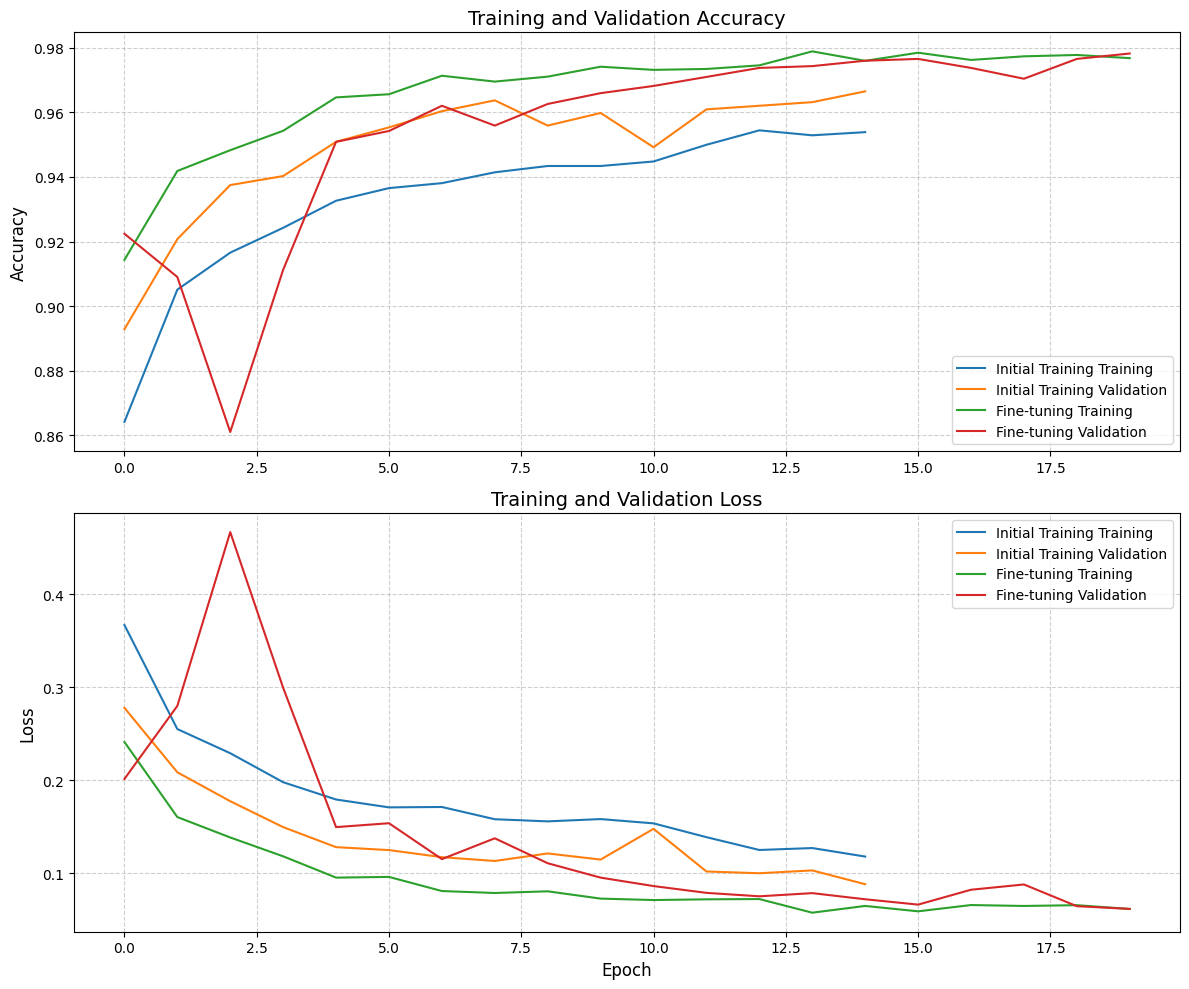

In [19]:
# Plot training metrics
def plot_training_history(history_list, titles):
    """
    Plot training and validation accuracy/loss curves
    
    Args:
        history_list: List of training history objects
        titles: List of labels for each history object
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot accuracy
    for i, history in enumerate(history_list):
        ax1.plot(history.history['accuracy'], label=f'{titles[i]} Training')
        ax1.plot(history.history['val_accuracy'], label=f'{titles[i]} Validation')
    
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Training and Validation Accuracy', fontsize=14)
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Plot loss
    for i, history in enumerate(history_list):
        ax2.plot(history.history['loss'], label=f'{titles[i]} Training')
        ax2.plot(history.history['val_loss'], label=f'{titles[i]} Validation')
    
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_title('Training and Validation Loss', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.savefig(str(models_dir / 'training_history.png'), dpi=300)
    plt.show()

# Plot the combined training history
plot_training_history(
    [history_head, history_fine_tune_1],
    ['Initial Training', 'Fine-tuning']
)

### 6.4 Generate Confusion Matrix

1/1 [==============================] - 1s 769ms/step


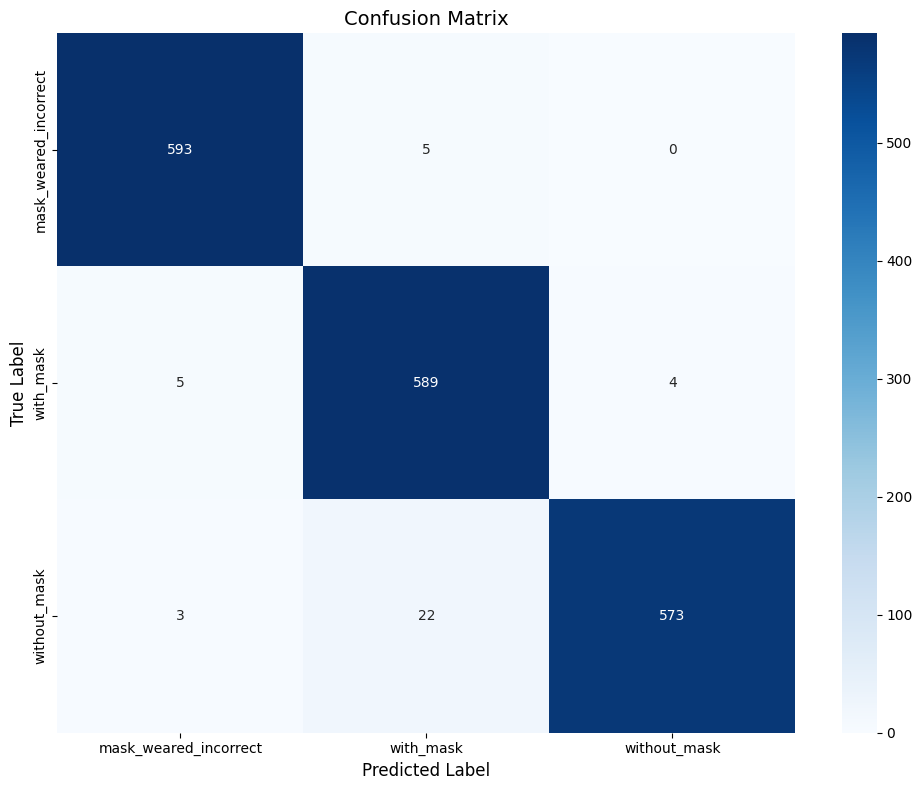


Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.99      0.99      0.99       598
            with_mask       0.96      0.98      0.97       598
         without_mask       0.99      0.96      0.98       598

             accuracy                           0.98      1794
            macro avg       0.98      0.98      0.98      1794
         weighted avg       0.98      0.98      0.98      1794



In [20]:
# Reset the validation generator
validation_generator.reset()

# Get predictions
y_pred = []
y_true = []

# Predict on validation data
for i in range(len(validation_generator)):
    x, y = validation_generator[i]
    pred = model.predict(x)
    y_pred.extend(np.argmax(pred, axis=1))
    y_true.extend(np.argmax(y, axis=1))
    
    # Break after going through all batches
    if (i+1) * BATCH_SIZE >= validation_generator.samples:
        break

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(str(models_dir / 'confusion_matrix.png'), dpi=300)
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

### 6.5 Final Evaluation

In [21]:
# Evaluate the model on validation data
validation_generator.reset()
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Final validation accuracy: {val_acc:.4f}")
print(f"Final validation loss: {val_loss:.4f}")

57/57 [==============================] - 2s 39ms/step - loss: 0.0613 - accuracy: 0.9783
Final validation accuracy: 0.9783
Final validation loss: 0.0613
